In [1]:
import numpy as np
from numpy import sin,cos,pi
from scipy.linalg import *
from scipy.optimize import fsolve,root
import matplotlib.pyplot as plt

# Kinematics

**Kinematics** is the study of the geometry of motion e.g. definitions of position, velocity, and acceleration

In this notebook we will explore kinematically-driven systems where the system degrees of freedom, $n_{d}=0 = 3\times n_b -n_c$, for planar problems. $n_b$ bodies moving in a plane have $3\times n_b$ degrees of freedom and the number of constraints is $n_c$.

![Coordinate system of rigid body](https://learning.oreilly.com/library/view/computational-dynamics-3rd/9780470686157/figs/0303.png)

In the figure above, there are three position vectors, $\mathbf{r}^{i}$, $\mathbf{R}^{i}$, and $\mathbf{u}^{i}$ and two coordinate systems, $X$-$Y$ and $X^{i}$-$Y^{i}$.

The $X^{i}$-$Y^{i}$ coordinate system moves with the rigid body and the point P is always in a fixed position $\mathbf{\bar{u}}^{i}_{P}=\bar{x}^{i}_{P}\hat{i}^{i}+\bar{y}^{i}_{P}\hat{j}^{i}$ in this coordinate system. 

$\mathbf{u}^{i}_{P} = \left[ \begin{array}{cc}
\cos \theta^i & -\sin \theta^i \\
\sin \theta^i & \cos \theta^i \\
\end{array} \right]
\left[\begin{array}{c} 
\bar{x}^{i}_{P} \\ 
\bar{y}^{i}_{P}\end{array}\right]$

or

$\mathbf{u}_{P}^{i}=\mathbf{A}^{i}\mathbf{\bar{u}}^{i}_{P}$

## Problem 1

Define a function of $\theta^i$ that returns the array $\mathbf{A}^i(\theta^i)$.

In [2]:
def rotA(theta):
    '''This function returns a 2x2 rotation matrix to convert the 
    rotated coordinate to the global coordinate system
    input is angle in radians'''
    A=np.zeros((2,2))
    # your work here
    
    return A

In [3]:
rotA(np.pi/4)


array([[0., 0.],
       [0., 0.]])

![](https://learning.oreilly.com/library/view/computational-dynamics-3rd/9780470686157/figs/0335.png)

![](https://learning.oreilly.com/library/view/computational-dynamics-3rd/9780470686157/figs/0336.png)

Figs. 3.35-36 Slider crank mechanism and body coordinate systems.

# Computational Kinematics of Slider crank

Here we will create the computational kinematics of the slider crank in Fig. 3.35-3.36 above.

The first kinematic problem will be to drive the slider crank with a constant $\dot{\theta}^{2}$ constraint. 

Below we set up the function to return the constraint equations, 

$\mathbf{C}(\mathbf{q},t)$ = `C_slidercrank(q,t)`

In [4]:
def links():
    '''function to define lengths of links for bodies 2 and 3 
    in Fig. 3.35-3.36'''
    l2=0.075*2
    l3=0.175*2
    
    return l2,l3

def C_slidercrank(q,t):
    '''12 constraint equations for 12 generalized coords
       q=[R1x,R1y,a1,R2x,R2y,a2,R3x,R3y,a3,R4x,R4y,a4]
       q=[R1,     a1,  R2,  ,a2,  R3,  ,a3,  R4,  ,a4]
         [0,1     2    3,4   5    6,7   8    9,10  11]
         
          2/\3
          /  \    slider-crank mechanism
         1    4 
        ^^^---------'''
    #l2=1
    #l3=1
    l2,l3=links()
    q=np.reshape(q,(12,-1))
    C=np.zeros((12,1))
    C[0:3]=q[0:3]
    C[3:5]=q[3:5]+rotA(q[5][0])@np.array([[-l2/2],[0]])
    C[5:7]=q[3:5]-q[6:8]+rotA(q[5][0])@np.array([[l2/2],[0]])-rotA(q[8][0])@np.array([[-l3/2],[0]])
    C[7:9]=q[6:8]-q[9:11]+rotA(q[8][0])@np.array([[l3/2],[0]])-rotA(q[11][0])@np.array([[0],[0]])
    C[9]=q[10]
    C[10]=q[11]
    C[11]=q[5]-pi/6-150*t
    return C.reshape(12)


Next, we set up the $12\times 12$ Jacobian of 

1. each pin $\mathbf{C_{q,~pin}}=\frac{\partial\mathbf{C_{pin}}}{\partial\mathbf{q}}$=`Cq_pin`

2. the total system: $\mathbf{C_{q}}=\frac{\partial\mathbf{C}}{\partial\mathbf{q}}$=`Cq_slidercrank`

In [5]:
def A_theta(theta):
    dAda=np.array([[-np.sin(theta), -np.cos(theta)],[np.cos(theta),-np.sin(theta)]])
    return dAda

def Cq_pin(u1,a1,u2,a2):
    '''Jacobian of a pinned constraint for planar motion
    inputs are positions of each body center, u1 and u2,
    and each body angle, a1 and a2
    In the generalized coordinates for body 1 and 2 they are inputs:
    u1=R1=[x^1,y^1]
    a1=theta^1
    u2=R2=[x^2,y^2]
    a2=theta^2'''
    u1=np.reshape(u1,(2,-1))
    u2=np.reshape(u2,(2,-1))
    Cq_1=np.append(np.identity(2),A_theta(a1)@u1[0:2],axis=1)
    Cq_2=np.append(-np.identity(2),-A_theta(a2)@u2[0:2],axis=1)
    Cq_pin=np.append(Cq_1,Cq_2,axis=1)
    return Cq_pin

def Cq_slidercrank(q,t):
    '''return Jacobian of C_slidercrank(q,t) = dC/dq_i
       |dC1/dR1x dC1/dR1y ... dC12/da4 |
       |dC2/dR1x dC2/dR1y ... dC12/da4 |
       |... ..     .           ...     |
       |            .                  |
       |             .                 |
       |dC12/dR1x ...         dC12/da4 |'''
    #l2=1
    #l3=1
    l2,l3=links()
    q=np.reshape(q,(12,-1))
    Cq=np.zeros((12,12))
    Cq[0:3,0:3]=np.identity(3)
    Cq[3:5,0:6]=-Cq_pin(np.array([[0],[0]]),q[2][0],np.array([[-l2/2], [0]]),q[5][0])
    Cq[5:7,3:9]=Cq_pin(np.array([[l2/2],[0]]),q[5][0],np.array([[-l3/2], [0]]),q[8][0])
    Cq[7:9,6:12]=Cq_pin(np.array([[l3/2],[0]]),q[8][0],np.array([[0], [0]]),q[11][0])
    Cq[9:11,10:12]=np.identity(2)
    Cq[11,5]=1
    return Cq

Now, we solve for 1 full rotation of the driven crank. 

t= 0-360$^o$ = 0-2$\pi$/150

The solution requires an initial guess for the generalized coordinates, $\mathbf{q}$, set as `q0`. It is updated at each timestep to find the next solution. 

In [6]:
t=np.linspace(0,2*pi/150)
q0=np.array([0,0,0, 0,0.5,pi/2, 0,0.5,-pi/3, 0,0,0])
q=np.zeros((len(q0),len(t)))
q[:,0]=q0
for i,tt in enumerate(t):
    q[:,i]=fsolve(lambda q: C_slidercrank(q,tt),q0,\
                    fprime= lambda q: Cq_slidercrank(q,tt))
    q0=q[:,i]


/opt/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Now, we can create the same figures as Shabana ch 3

![](https://learning.oreilly.com/library/view/computational-dynamics-3rd/9780470686157/figs/0337a.png)

Fig. 3.37. Orientation of the connecting rod

![](https://learning.oreilly.com/library/view/computational-dynamics-3rd/9780470686157/figs/0338a.png)

Fig. 3.38. Displacement of the slider block

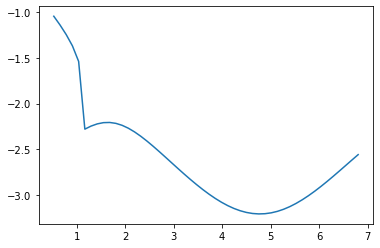

In [7]:
plt.plot(q[5,:],q[8,:])
#plt.plot(t,q[5,:]/pi*180)

# Problem 2

Recreate the displacement of the slider block graph in Fig. 3.38 from our solution.

In [8]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [9]:
def plot_shape(shape,dims,q):
    if shape=='link':
        Px=q[0]+np.array([dims[0]/2*np.cos(q[-1]),-dims[0]/2*np.cos(q[-1])])
        Py=q[1]+np.array([dims[0]/2*np.sin(q[-1]),-dims[0]/2*np.sin(q[-1])])
        l,= plt.plot(Px,Py,'o-')
        return l
    elif shape=='base':
        Px=q[0]
        Py=q[1]
        l,=plt.plot(Px,Py,'s',markersize=20)
        return l
    else:
        print('choose a \'link\' or \'base\' please')
        return 0

def plot_qs(q,shapes,dims,i):
    qi=q[:,i]
    f=plt.figure()
    if len(qi)/3 !=len(shapes):
        print('len(q) is %i. It needs %i more shapes '%(len(qi),len(qi)/3-len(shapes)))
    elif len(qi)/3==len(shapes):
        for i,s in enumerate(shapes):
            plot_shape(s,dims[i],qi[3*i:3*i+3])
            plt.plot(q[3*i,:],q[3*i+1,:])
        a=f.gca()
        l2,l3=links()
        plt.title('Angle 2 = %1.1f deg'%(qi[5]*180/pi))
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        a.axis([-l2*1.1, (l2+l3)*1.1, -l2*1.5, l2*1.5])
    #return f
    
    

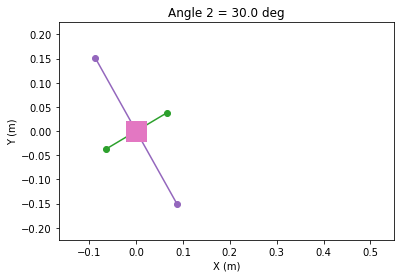

In [10]:
l2,l3=links()
f=plot_qs(q,['base','link','link','base'],[[ ],[l2],[l3],[ ]],0)

In [11]:
interact(lambda i: plot_qs(q,['base','link','link','base'],[[ ],[l2],[l3],[ ]],i), i=(0,49))


interactive(children=(IntSlider(value=24, description='i', max=49), Output()), _dom_classes=('widget-interact'…

<function __main__.<lambda>(i)>

## Velocity and Acceleration

Differentiating the constraint equations, $\mathbf{Cq}=\mathbf{0}$, 

$\mathbf{C_q \dot{q}}+\mathbf{C}_t=\mathbf{0}$ (3.119)

where 

$\mathbf{C}_t = \left[\frac{\partial C_1}{\partial t} \frac{\partial C_2}{\partial t}
... \frac{\partial C_n}{\partial t}\right]^T$ (3.120)

Therefore, the velocity of each $\mathbf{\dot{q}_i}$ is solveed with

$\mathbf{C_q \dot{q}}=-\mathbf{C}_t$ (3.121)

Differentiating $\mathbf{Cq}=\mathbf{0}$ twice leads to the acceleration equation

$\mathbf{C_q \ddot{q}}+
\left(\mathbf{C_q \dot{q}}\right)_{\mathbf{q}}\mathbf{\dot{q}}+
2\mathbf{C}_{\mathbf{q}t}\mathbf{\dot{q}}+
\mathbf{C}_{tt}=\mathbf{0}$ (3.123)

where the accelerations, $\mathbf{\ddot{q}_i}$ are solve with

$\mathbf{C_q \ddot{q}}=\mathbf{Q}_d$

where 

$\mathbf{Q}_d=-\left(\mathbf{C_q \dot{q}}\right)_{\mathbf{q}}\mathbf{\dot{q}}-
2\mathbf{C}_{\mathbf{q}t}\mathbf{\dot{q}}-
\mathbf{C}_{tt}$

Here, we set up `vel_acc(q,t)` to return velocity and acceleration of $\mathbf{q_{i}}$ components as $\frac{d\mathbf{q}}{dt}$ and $\frac{d^2\mathbf{q}}{dt^2}$ (`dq` and `ddq`, respectively)

In [12]:
def vel_acc(q,t):
    l2,l3=links()
    Ct=np.zeros(q.shape)
    Ct[-1]=150
    dq=np.linalg.solve(Cq_slidercrank(q,t),Ct)
    Qd=np.zeros(q.shape)
    Qd[3:5]=np.reshape(dq[5]**2*rotA(q[5])@np.array([[-l2/2],[0]]),2)
    Qd[5:7]=np.reshape(dq[5]**2*rotA(q[5])@np.array([[l2/2],[0]])-\
        dq[8]**2*rotA(q[8])@np.array([[-l3/2],[0]]),2)
    Qd[7:9]=np.reshape(dq[8]**2*rotA(q[8])@np.array([[l3/2],[0]])-\
        dq[11]**2*rotA(q[11])@np.array([[0],[0]]),2)
    ddq=np.linalg.solve(Cq_slidercrank(q,t),Qd)
    return dq,ddq
    

In [13]:
qv=np.zeros(q.shape)
qa=np.zeros(q.shape)
for i in range(0,len(t)):
    v,a=vel_acc(q[:,i],t[i])
    qv[:,i]=v
    qa[:,i]=a
    

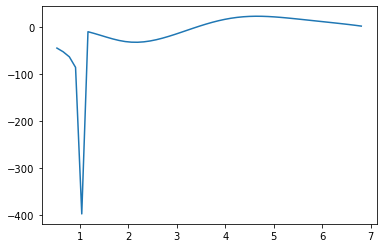

In [14]:
#plt.plot(q[5,:],qv[8,:])
plt.plot(q[5,:],qv[9,:])

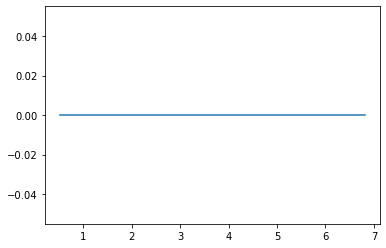

In [15]:

plt.plot(q[5,:],qa[9,:])

# Problem 3

Change the constraints for the slidercrank such that 

$R^4_x-f(t)=0$

where

$f(t)=0.35-0.8l^2\sin150t$

Recreate Figs. 3.43-3.48 for the slidercrank.

![](https://learning.oreilly.com/library/view/computational-dynamics-3rd/9780470686157/figs/0340a.png)
![](https://learning.oreilly.com/library/view/computational-dynamics-3rd/9780470686157/figs/0340b.png)

![](https://learning.oreilly.com/library/view/computational-dynamics-3rd/9780470686157/figs/0341a.png)
![](https://learning.oreilly.com/library/view/computational-dynamics-3rd/9780470686157/figs/0341b.png)

![](https://learning.oreilly.com/library/view/computational-dynamics-3rd/9780470686157/figs/0342a.png)
![](https://learning.oreilly.com/library/view/computational-dynamics-3rd/9780470686157/figs/0342b.png)